# Coding Assignment 2

Jacob Albus (albus2, Campus) and Ashish Pabba (apabba2, MCS-DS)

## Part 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("data/Coding2_Data.csv")

var_names = data.columns
y = data[['Y']].to_numpy()
X = data.drop(['Y'], axis = 1).to_numpy()
print(X.shape, y.shape)

(506, 13) (506, 1)


In [3]:
def one_var_lasso(v, z, lam):
    z_norm = z.T @ z
    a =  (v.T @ z) / z_norm
    ita = (len(z) * lam) / z_norm
    
    if a > ita:
        return a - ita
    elif a < -ita:
        return a + ita
    else:
        return 0

In [4]:
def MyLasso(X, y, lam_seq, maxit = 100):
   
    # Input
    # X: n-by-p design matrix without the intercept
    # y: n-by-1 response vector
    # lam.seq: sequence of lambda values (arranged from large to small)
    # maxit: number of updates for each lambda
   
    # Output
    # B: a (p+1)-by-len(lam.seq) coefficient matrix
    #    with the first row being the intercept sequence

    n, p = X.shape
    nlam = len(lam_seq)
    B = np.zeros((p+1, nlam))
   
    ##############################
    # YOUR CODE:
    # (1) newX = Standardizad X;
    # (2) Record the centers and scales used in (1)
    ##############################
    x_means = np.mean(X, axis=0)
    x_sd = np.std(X, axis=0)
    newX = (X - x_means) / x_sd

    # Initilize coef vector b and residual vector r
    b = np.zeros(p)
    r = y

    # Triple nested loop
    for m in range(nlam):
        for step in range(maxit):
            for j in range(p):
                X_j = newX[:, j].reshape(-1,1)
                r = r + X_j * b[j]
                b[j] = one_var_lasso(r, X_j, lam_seq[m])
                r = r - X_j * b[j]
        B[1:, m] = b
   
    ##############################
    # YOUR CODE:
    # Scale back the coefficients;
    # Update the intercepts stored in B[, 0]
    ##############################
    for m in range(nlam):
        B[1:, m] /= x_sd
        B[0, m] = y.mean() - (x_means @ B[1:, m])

    return(B)

In [5]:
log_lam_seq = np.linspace(-1, -8, num = 80)
lam_seq = np.exp(log_lam_seq)
myout = MyLasso(X, y, lam_seq, maxit = 100)

In [6]:
lasso_coef = pd.read_csv("data/Coding2_lasso_coefs.csv").to_numpy()

print(abs(myout - lasso_coef).max())

0.004645317415915784


(-8.35, -0.6499999999999999, -0.30999458351285203, 0.49974219884805027)

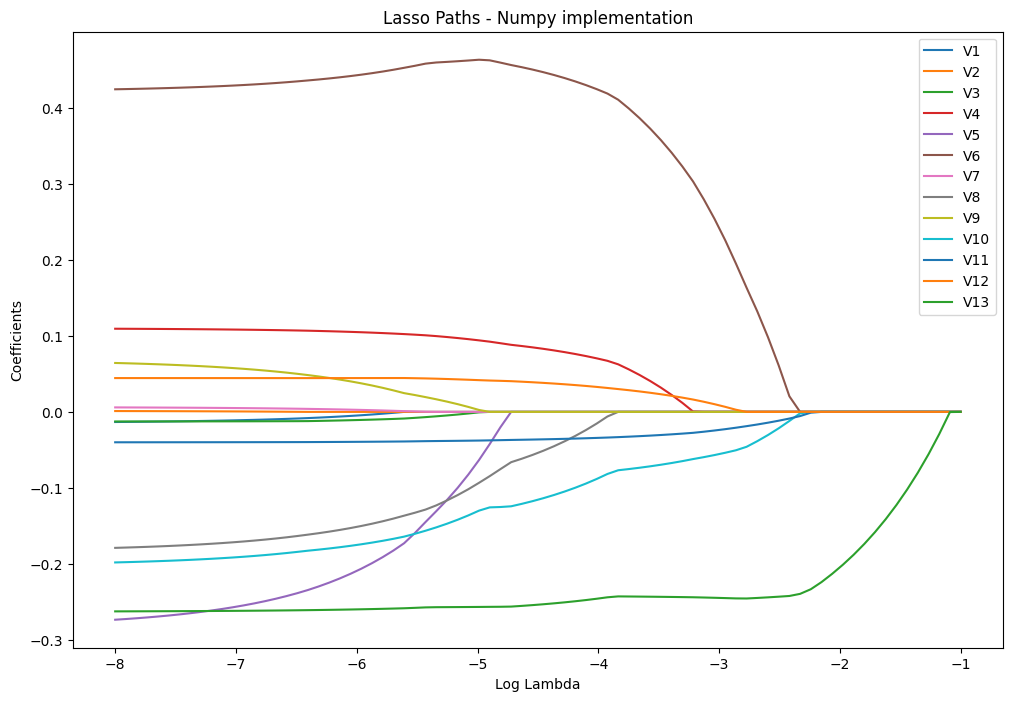

In [7]:
p, _ = myout.shape
plt.figure(figsize = (12,8))

for i in range(p-1):
    plt.plot(log_lam_seq, myout[i+1, :], label = var_names[i])

plt.xlabel('Log Lambda')
plt.ylabel('Coefficients')
plt.title('Lasso Paths - Numpy implementation')
plt.legend()
plt.axis('tight')

## Part 2

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as lm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from collections import defaultdict

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [9]:
class PCR(object):

    def __init__(self, num_folds=10):
        self.folds = num_folds

    def fit(self, X, Y):
        n, p = X.shape
        indices = np.arange(n)
        np.random.shuffle(indices)
        index_sets = np.array_split(indices, self.folds)
        ncomp = min(p, n - 1 - max([len(i) for i in index_sets]))
        cv_err = np.zeros(ncomp)

        for ifold in range(self.folds):
            train_inds =  np.delete(index_sets, obj=ifold, axis=0).ravel()
            test_inds = index_sets[ifold]

            X_train = X[train_inds, :]
            pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA())])
            pipeline.fit(X_train)
            X_train = pipeline.transform(X_train)
            coefs = Y[train_inds].T @ X_train / np.sum(X_train**2, axis=0)
            b0 = np.mean(Y[train_inds])

            X_test = pipeline.transform(X[test_inds, :])

            for k in np.arange(ncomp):
                preds = X_test[:, :k] @ coefs.T[:k] + b0
                cv_err[k] += cv_err[k] + np.sum((Y[test_inds]-preds)**2)

        min_ind = np.argmin(cv_err)
        self.ncomp = min_ind+1
        pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=self.ncomp))])
        self.transform = pipeline.fit(X)
        self.model = lm().fit(self.transform.transform(X), Y)

    def predict(self, X):
        X_ = self.transform.transform(X)
        return self.model.predict(X_)

In [10]:
def lasso_cv(X_train, Y_train):
    lasso_alphas = np.logspace(-10, 1, 100)
    lassocv = LassoCV(alphas = lasso_alphas, cv = 10)
    lassocv.fit(X_train, Y_train)

    mean_mse = np.mean(lassocv.mse_path_, axis=1)
    std_mse = np.std(lassocv.mse_path_, axis=1) / np.sqrt(10) 
    
    cv_alphas = lassocv.alphas_
    min_idx = np.argmin(mean_mse)
    
    alpha_min = cv_alphas[min_idx]
    
    threshold = mean_mse[min_idx] + std_mse[min_idx]
    alpha_1se = max(cv_alphas[np.where(mean_mse <= threshold)])
    
    return alpha_min, alpha_1se

In [11]:
def ridge_cv(X_train, Y_train):
    ridge_alphas = np.logspace(-10, 1, 100)
    ridgecv = RidgeCV(alphas = ridge_alphas, cv = 10, 
                      scoring = 'neg_mean_squared_error')
    ridgecv.fit(X_train, Y_train)
    return ridgecv.alpha_

In [12]:
def get_test_errors(X, Y, num_iters=50):
    error_data = defaultdict(list)
    
    n = len(Y)
    
    for i in range(num_iters):
        if i % 10 == 0:
            print("Currently on", i, "th iteration")
            
        indices = np.arange(0, n)
        np.random.shuffle(indices)
        test_ind = indices[:int(np.floor(0.25*n))]
        train_ind = indices[len(test_ind):]
        
        # Splitting the data into training and testing sets
        X_train = X.iloc[train_ind]
        Y_train = Y[train_ind]
        X_test = X.iloc[test_ind]
        Y_test = Y[test_ind]

        # Full/OLS model
        full = lm().fit(X_train, Y_train)
        error_data["error"].append(mean_squared_error(Y_test, full.predict(X_test)))
        error_data["model_type"].append("ols")

        # Ridge Errors
        ridge_lambda = ridge_cv(X_train, Y_train)
        ridge_model = Ridge(alpha = ridge_lambda)
        ridge_model.fit(X_train, Y_train)
        error_data["error"].append(mean_squared_error(Y_test, ridge_model.predict(X_test)))
        error_data["model_type"].append("ridge")

        # Lasso Errors
        lambda_min, lambda_1se = lasso_cv(X_train, Y_train)

        lasso_model_min = Lasso(alpha = lambda_min, max_iter=10000)
        lasso_model_min.fit(X_train, Y_train)
        error_data["error"].append(mean_squared_error(Y_test, lasso_model_min.predict(X_test)))
        error_data["model_type"].append("lasso_min")
        
        lasso_model_1se = Lasso(alpha = lambda_1se, max_iter=10000)
        lasso_model_1se.fit(X_train, Y_train)
        error_data["error"].append(mean_squared_error(Y_test, lasso_model_1se.predict(X_test)))
        error_data["model_type"].append("lasso_1se")
        
        # Lasso Refit error
        nonzero_indices = np.where(lasso_model_1se.coef_ != 0)[0]
        lm_refit = lm()
        lm_refit.fit(X_train.iloc[:, nonzero_indices], Y_train)
        error_data["error"].append(mean_squared_error(Y_test, lm_refit.predict(X_test.iloc[:, nonzero_indices])))
        error_data["model_type"].append("lasso_refit")

        # PCR model
        pcr = PCR()
        pcr.fit(X_train.to_numpy(), Y_train.to_numpy())
        error_data["error"].append(mean_squared_error(Y_test, pcr.predict(X_test.to_numpy())))
        error_data["model_type"].append("pcr")
    
    return error_data

### Case 1

In [13]:
np.random.seed(8067)

data = pd.read_csv("data/Coding2_Data.csv")
Y = data['Y']
X = data.drop(['Y'], axis = 1)
print(X.shape, Y.shape)

scalerX = StandardScaler()
scalerX.fit(X)
newX = pd.DataFrame(scalerX.transform(X))

y_mean = Y.mean()
y_std = Y.std()
newY = pd.Series((Y - y_mean) / y_std)

error_data = get_test_errors(newX, newY, num_iters=50)

(506, 13) (506,)
Currently on 0 th iteration
Currently on 10 th iteration
Currently on 20 th iteration
Currently on 30 th iteration
Currently on 40 th iteration


<Axes: xlabel='model_type', ylabel='error'>

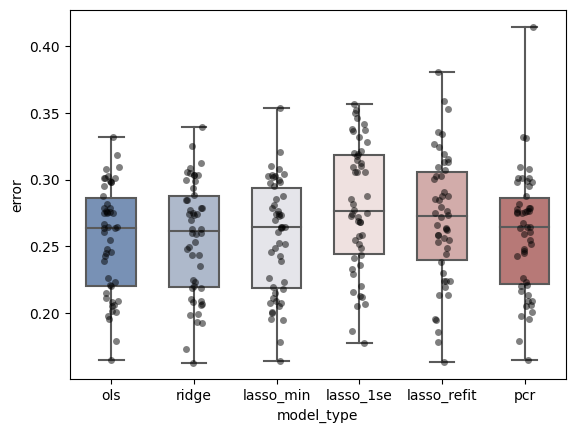

In [16]:
import seaborn as sns

sns.boxplot(data=error_data, x="model_type", y="error",
            whis=[0, 100], width=.6, palette="vlag")
sns.stripplot(data=error_data, x="model_type", y="error", color="black", alpha=0.5)

In [24]:
error_data1_types = defaultdict(list)

for index, model_type in enumerate(error_data["model_type"]):
    error_data1_types[model_type].append(error_data["error"][index])

for model_type in error_data1_types:
    print(model_type, "error mean:", np.mean(error_data1_types[model_type]))

ols error mean: 0.2558606826001975
ridge error mean: 0.25611076872751815
lasso_min error mean: 0.257007486613802
lasso_1se error mean: 0.27972880261108524
lasso_refit error mean: 0.2710125729337166
pcr error mean: 0.2602001287113302


#### Which procedure or procedures yield the best performance in terms of MSPE?

All models perform about the same, but the Full "ols" model has the lowest median MSPE giving it the best performance

#### Conversely, which procedure or procedures show the poorest performance?

Lasso.1se has the highest median MSPE giving it the worst performance.

#### In the context of Lasso regression, which procedure, Lasso.min or Lasso.1se, yields a better MSPE?

Lasso.min gives the better performance and yields the lowest MSPE

#### Is refitting advantageous in this case? In other words, does L.Refit outperform Lasso.1se

Lasso Refit actually has worse performance and yields higher MSPE than both Lasso.min and Lasso.1se.

#### Is variable selection or shrinkage warranted for this particular dataset? To clarify, do you find the performance of the Full model to be comparable to, or divergent from, the best-performing procedure among the other five?

All models perform about the same, and the Full "ols" model does marginally outperform the regularized models. I would say that for this dataset shrinkage and/or variable selection is not necessary for basic prediction, but may still be helpful for inference.

### Case 2

In [17]:
data = pd.read_csv("data/Coding2_Data3.csv")
Y = data['Y']
X = data.drop(['Y'], axis = 1)
print(X.shape, Y.shape)

scalerX = StandardScaler()
scalerX.fit(X)
newX = pd.DataFrame(scalerX.transform(X))

y_mean = Y.mean()
y_std = Y.std()
newY = pd.Series((Y - y_mean) / y_std)

error_data2 = get_test_errors(newX, newY, num_iters=50)

(506, 591) (506,)
Currently on 0 th iteration
Currently on 10 th iteration
Currently on 20 th iteration
Currently on 30 th iteration
Currently on 40 th iteration


<Axes: xlabel='model_type', ylabel='error'>

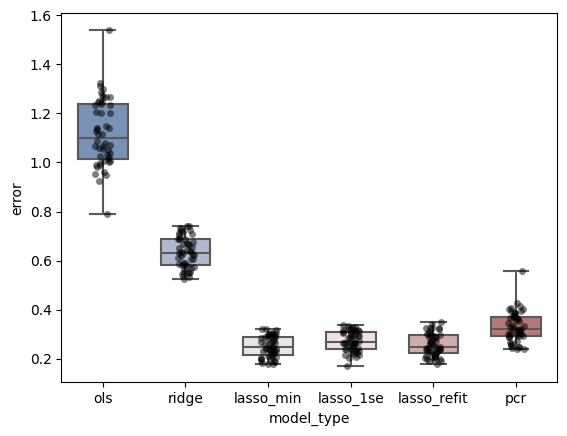

In [18]:
import seaborn as sns

sns.boxplot(data=error_data2, x="model_type", y="error",
            whis=[0, 100], width=.6, palette="vlag")
sns.stripplot(data=error_data2, x="model_type", y="error", color="black", alpha=0.5)

<Axes: xlabel='model_type', ylabel='error'>

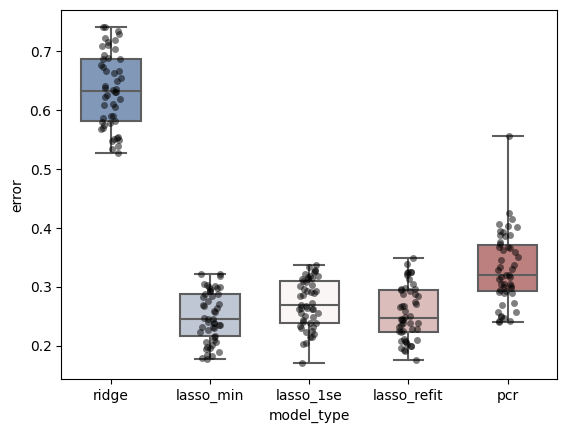

In [19]:
error_data2_no_ols = defaultdict(list)

for index, model_type in enumerate(error_data2["model_type"]):
    if model_type == "ols":
        continue
    error_data2_no_ols["model_type"].append(model_type)
    error_data2_no_ols["error"].append(error_data2["error"][index])

sns.boxplot(data=error_data2_no_ols, x="model_type", y="error",
            whis=[0, 100], width=.6, palette="vlag")
sns.stripplot(data=error_data2_no_ols, x="model_type", y="error", color="black", alpha=0.5)

In [27]:
error_data2_types = defaultdict(list)

for index, model_type in enumerate(error_data2["model_type"]):
    error_data2_types[model_type].append(error_data2["error"][index])

for model_type in error_data1_types:
    print(model_type, "error mean:", np.mean(error_data2_types[model_type]))
print("")
for model_type in error_data1_types:
    print(model_type, "error mean difference:", np.mean(error_data2_types[model_type]) - np.mean(error_data1_types[model_type]))

ols error mean: 1.1209027747650548
ridge error mean: 0.6339952761375173
lasso_min error mean: 0.24950621688986938
lasso_1se error mean: 0.2716641744656153
lasso_refit error mean: 0.25626574911630373
pcr error mean: 0.3308022051396634

ols error mean difference: 0.8650420921648574
ridge error mean difference: 0.3778845074099991
lasso_min error mean difference: -0.007501269723932641
lasso_1se error mean difference: -0.008064628145469932
lasso_refit error mean difference: -0.01474682381741288
pcr error mean difference: 0.07060207642833322


#### Which procedure or procedures yield the best performance in terms of MSPE?

We now have lasso min with the lowest average MSPE and therefore the best performance.

#### Conversely, which procedure or procedures show the poorest performance?

Ridge regression now has the highest average MSPE and therefore the worst performance.

#### Have you observed any procedure or procedures that performed well in Case I but exhibited poorer performance in Case II, or vice versa? If so please offer an explanation

Ridge regression performed very well in Case I but is significantly worse than the others in Case II. This is likely because Ridge regression isn't able to fully push coefficients for noise features to 0.

#### Given that Coding2_Data3.csv includes all features found in Coding2_Data2.csv, one might anticipate that the best MSPE in Case II would be equal to or lower than the best MSPE in Case I. Do your simulation results corroborate this expectation? If not, please offer an explanation.

For the ridge and pcr model, we observe greater averae MSPE. For lasso min, lasso 1se, and lasso refit, we observe slightly lower average MSPE error.  Even though all the original features from Case I are in Case II, the extra features means that during training the models are more susceptible to overfitting. So for a model like ridge regression, it can't totally shrink the coefficients for noise vectors meaning that it'll overfit and will have high prediction error on the test data. However, lasso based models are able to totally shrink the coefficients for noise vectors, so they don't see an increase in MSPE for Case II.